In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

### Generating data

In [118]:
def cluster_generation(n=1000, m=15, k=7, a=1, random_state=12):
    """
    Cluster generation function 
    Parameters: n-total number of elements, m-dimensionality(number of features), k-number of clusters, 
    a-parameter controlling the level of intermix among clusters
    """
    np.random.seed(random_state)
    
    #generating means
    means = np.random.uniform(low=-1*a, high=a, size=(k, m))
    
    #generating covariance matrix
    covariance_matrix = np.array([]).reshape((0, m, m))
    for i in range(k):
        diagonal = np.random.uniform(low=0.025*2, high=0.05*2, size=(m, m))
        covariance_matrix = np.concatenate((covariance_matrix, np.diag(np.diag(diagonal)).reshape((1,m,m))), axis=0)
        
    #defining cluster cardinality
    min_cardinality = 60
    proportions = np.sort(np.random.uniform(0,1,k-1))
    proportions = np.append(np.diff(proportions), proportions[0])
    cardinality = np.around(proportions*(n-min_cardinality*k)+min_cardinality)
    cardinality = np.append(cardinality, n-sum(cardinality)).astype(int)
    
    #generating clusters
    clusters = np.vstack([np.random.multivariate_normal(means[i], covariance_matrix[i], cardinality[i]) for i in range(k)])
    labels = np.vstack([np.ones(shape=(cardinality[i],1))*i for i in range(k)])
    
    return clusters, labels

In [3]:
def euclidean_distance(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))

In [4]:
X, y = cluster_generation()

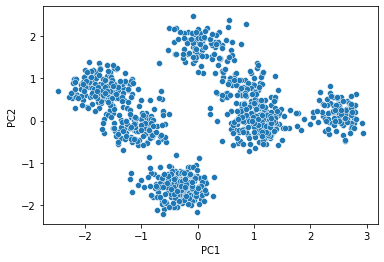

In [5]:
#Projection of generated 15D clusters to the plane of the first two principal components.

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data);

### Generating panom centroids

In [6]:
def borders(X, k=7):
    """
    Return: global center and lower and upper bounds for space of random cluster centroids selection
    """
    #generating 2k points on a half of max distance from global center
    global_center = np.mean(X, axis=0)
    max_distance = np.max(euclidean_distance(global_center, X))
    upper_bound = list()
    lower_bound = list()
    for _ in range(800):
        theta = 2 * np.pi * np.random.uniform()
        lower_bound.append((global_center[0] + max_distance/2 * np.cos(theta), global_center[1] + max_distance/2 * np.sin(theta)))
        upper_bound.append((global_center[0] + max_distance * np.cos(theta), global_center[1] + max_distance * np.sin(theta)))

    return global_center, lower_bound, upper_bound

In [14]:
def init_centroids(X, k=7):
    """
    Return: 2k points on a half of max distance from global center - centroids
    """
    global_center = np.mean(X, axis=0)
    max_distance = np.max(euclidean_distance(global_center, X))
    centroids = list()
    for _ in range(2*k):
        theta = 2 * np.pi * np.random.uniform()
        dist = max_distance/2 * (1 + np.random.uniform())
        centroids.append((global_center[0] + dist * np.cos(theta), global_center[1] + dist * np.sin(theta)))
    return centroids

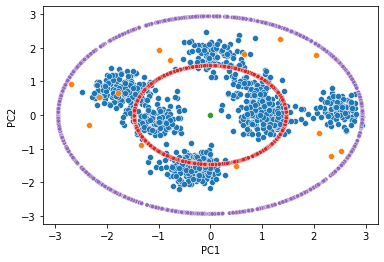

In [16]:
#Clusters, initial centroids, borders for centroids

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

sns.scatterplot(x="PC1",y="PC2",data=pca_data)

centroids = pd.DataFrame(init_centroids(pca_data),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=centroids);

global_center = pd.DataFrame(borders(pca_data)[0]).transpose()
lower_bound = pd.DataFrame(borders(pca_data)[1],columns=['PC1','PC2']) 
upper_bound = pd.DataFrame(borders(pca_data)[2],columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=global_center,palette='green');
sns.scatterplot(x="PC1",y="PC2",data=lower_bound,palette='green',size=0.8,legend=False);
sns.scatterplot(x="PC1",y="PC2",data=upper_bound,palette='green',size=0.8,legend=False);

In [69]:
class Panom:
    """
    Method for initialization cluster centroids
    """
    
    def __init__(self, n_clusters=7, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
    def init_centroids(self, X_train):
        #generating 2k points on a half of max distance from global center
        self.global_center = np.mean(X_train, axis=0)
        self.max_distance = np.max(euclidean_distance(self.global_center, X_train))
        self.points = list()
        for _ in range(2*self.n_clusters):
            theta = 2 * np.pi * np.random.uniform()
            dist = self.max_distance/2 * (1 + np.random.uniform())
            self.points.append((self.global_center[0] + dist * np.cos(theta), self.global_center[1] + dist * np.sin(theta)))
        #calculating cardinality for each potential cluster and drop points with the least cardinality
        for _ in range(2*self.n_clusters):
            sorted_points = np.zeros((2*self.n_clusters,))
            for _, x in X_train.iterrows():
                dists = [euclidean_distance(x, pd.DataFrame(self.points))]
                points_idx = np.argmin(dists)
                sorted_points[points_idx]+=1
        ind = np.argpartition(sorted_points, -self.n_clusters)[-self.n_clusters:]
        
        return np.array(self.points)[ind]

In [71]:
p = Panom()
centers = p.init_centroids(pca_data)

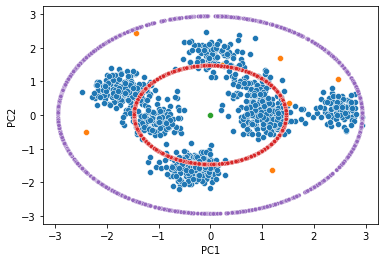

In [93]:
#Clusters, panom centroids, borders for centroids

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

sns.scatterplot(x="PC1",y="PC2",data=pca_data)

centroids = pd.DataFrame(centers,columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=centroids);

global_center = pd.DataFrame(borders(pca_data)[0]).transpose()
lower_bound = pd.DataFrame(borders(pca_data)[1],columns=['PC1','PC2']) 
upper_bound = pd.DataFrame(borders(pca_data)[2],columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=global_center,palette='green');
sns.scatterplot(x="PC1",y="PC2",data=lower_bound,palette='green',size=0.8,legend=False);
sns.scatterplot(x="PC1",y="PC2",data=upper_bound,palette='green',size=0.8,legend=False);

### Models comparison

In [119]:
model1 = KMeans(n_clusters=7)
model2 = KMeans(n_clusters=7, init=centers, n_init=1)
model3 = KMeans(n_clusters=7, init='random')

#### Intermix parameter *a=1*

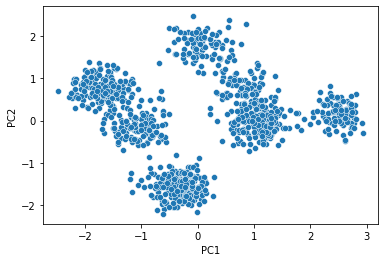

In [108]:
#Projection of generated 15D clusters to the plane of the first two principal components.

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data);

In [120]:
n_iter_1, n_iter_2, n_iter_3 = [], [], []
ari_1, ari_2, ari_3 = [], [], []

for state in range(10):
    X, y = cluster_generation(random_state=state)
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
    p = Panom()
    centers = p.init_centroids(pca_data)
    
    model1.fit(pca_data)
    model2.fit(pca_data)
    model3.fit(pca_data);
    
    ari_1.append(adjusted_rand_score(model1.labels_,y.reshape((1000,))))
    ari_2.append(adjusted_rand_score(model2.labels_,y.reshape((1000,))))
    ari_3.append(adjusted_rand_score(model3.labels_,y.reshape((1000,))))
    
    n_iter_1.append(model1.n_iter_)
    n_iter_2.append(model2.n_iter_)
    n_iter_3.append(model3.n_iter_)

In [121]:
print(f'ARI for k-means++ initialization: {np.mean(ari_1)}')
print(f'ARI for panom initialization: {np.mean(ari_2)}')
print(f'ARI for random initialization: {np.mean(ari_3)}')

ARI for k-means++ initialization: 0.7439952390235138
ARI for panom initialization: 0.6760984239453155
ARI for random initialization: 0.7115307955606165


In [122]:
print(f'Number of iterations for k-means++ initialization: {np.mean(n_iter_1)}')
print(f'Number of iterations for panom initialization: {np.mean(n_iter_2)}')
print(f'Number of iterations for random initialization: {np.mean(n_iter_3)}')

Number of iterations for k-means++ initialization: 9.0
Number of iterations for panom initialization: 20.6
Number of iterations for random initialization: 12.9


#### Intermix parameter *a=0.75*

In [123]:
X, y = cluster_generation(a=0.75)
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

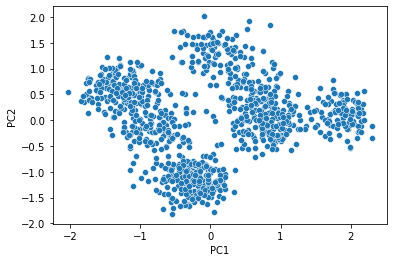

In [124]:
#Projection of generated 15D clusters to the plane of the first two principal components.

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data);

In [125]:
n_iter_1, n_iter_2, n_iter_3 = [], [], []
ari_1, ari_2, ari_3 = [], [], []

for state in range(10):
    X, y = cluster_generation(a=0.75, random_state=state)
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
    p = Panom()
    centers = p.init_centroids(pca_data)
    
    model1.fit(pca_data)
    model2.fit(pca_data)
    model3.fit(pca_data);
    
    ari_1.append(adjusted_rand_score(model1.labels_,y.reshape((1000,))))
    ari_2.append(adjusted_rand_score(model2.labels_,y.reshape((1000,))))
    ari_3.append(adjusted_rand_score(model3.labels_,y.reshape((1000,))))
    
    n_iter_1.append(model1.n_iter_)
    n_iter_2.append(model2.n_iter_)
    n_iter_3.append(model3.n_iter_)

In [126]:
print(f'ARI for k-means++ initialization: {np.mean(ari_1)}')
print(f'ARI for panom initialization: {np.mean(ari_2)}')
print(f'ARI for random initialization: {np.mean(ari_3)}')

ARI for k-means++ initialization: 0.6486468889313048
ARI for panom initialization: 0.633813663947053
ARI for random initialization: 0.6374598930934287


In [127]:
print(f'Number of iterations for k-means++ initialization: {np.mean(n_iter_1)}')
print(f'Number of iterations for panom initialization: {np.mean(n_iter_2)}')
print(f'Number of iterations for random initialization: {np.mean(n_iter_3)}')

Number of iterations for k-means++ initialization: 13.8
Number of iterations for panom initialization: 19.5
Number of iterations for random initialization: 14.6


#### Intermix parameter *a=0.5*

In [129]:
X, y = cluster_generation(a=0.5)
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

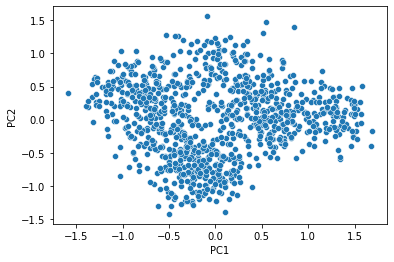

In [130]:
#Projection of generated 15D clusters to the plane of the first two principal components.

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data);

In [131]:
n_iter_1, n_iter_2, n_iter_3 = [], [], []
ari_1, ari_2, ari_3 = [], [], []

for state in range(10):
    X, y = cluster_generation(a=0.5, random_state=state)
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
    p = Panom()
    centers = p.init_centroids(pca_data)
    
    model1.fit(pca_data)
    model2.fit(pca_data)
    model3.fit(pca_data);
    
    ari_1.append(adjusted_rand_score(model1.labels_,y.reshape((1000,))))
    ari_2.append(adjusted_rand_score(model2.labels_,y.reshape((1000,))))
    ari_3.append(adjusted_rand_score(model3.labels_,y.reshape((1000,))))
    
    n_iter_1.append(model1.n_iter_)
    n_iter_2.append(model2.n_iter_)
    n_iter_3.append(model3.n_iter_)

In [132]:
print(f'ARI for k-means++ initialization: {np.mean(ari_1)}')
print(f'ARI for panom initialization: {np.mean(ari_2)}')
print(f'ARI for random initialization: {np.mean(ari_3)}')

ARI for k-means++ initialization: 0.4760537176721411
ARI for panom initialization: 0.5285732762402403
ARI for random initialization: 0.4726394255231169


In [133]:
print(f'Number of iterations for k-means++ initialization: {np.mean(n_iter_1)}')
print(f'Number of iterations for panom initialization: {np.mean(n_iter_2)}')
print(f'Number of iterations for random initialization: {np.mean(n_iter_3)}')

Number of iterations for k-means++ initialization: 14.8
Number of iterations for panom initialization: 28.1
Number of iterations for random initialization: 22.8


#### Intermix parameter *a=0.25*

In [134]:
X, y = cluster_generation(a=0.25)
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

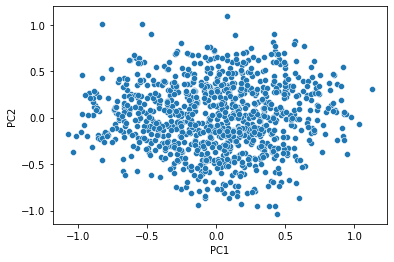

In [135]:
#Projection of generated 15D clusters to the plane of the first two principal components.

pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data);

In [139]:
n_iter_1, n_iter_2, n_iter_3 = [], [], []
ari_1, ari_2, ari_3 = [], [], []

for state in range(10):
    X, y = cluster_generation(a=0.25, random_state=state)
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
    p = Panom()
    centers = p.init_centroids(pca_data)
    
    model1.fit(pca_data)
    model2.fit(pca_data)
    model3.fit(pca_data);
    
    ari_1.append(adjusted_rand_score(model1.labels_,y.reshape((1000,))))
    ari_2.append(adjusted_rand_score(model2.labels_,y.reshape((1000,))))
    ari_3.append(adjusted_rand_score(model3.labels_,y.reshape((1000,))))
    
    n_iter_1.append(model1.n_iter_)
    n_iter_2.append(model2.n_iter_)
    n_iter_3.append(model3.n_iter_)

In [140]:
print(f'ARI for k-means++ initialization: {np.mean(ari_1)}')
print(f'ARI for panom initialization: {np.mean(ari_2)}')
print(f'ARI for random initialization: {np.mean(ari_3)}')

ARI for k-means++ initialization: 0.19344025419219452
ARI for panom initialization: 0.19844626197734144
ARI for random initialization: 0.1961105859570892


In [141]:
print(f'Number of iterations for k-means++ initialization: {np.mean(n_iter_1)}')
print(f'Number of iterations for panom initialization: {np.mean(n_iter_2)}')
print(f'Number of iterations for random initialization: {np.mean(n_iter_3)}')

Number of iterations for k-means++ initialization: 23.6
Number of iterations for panom initialization: 24.1
Number of iterations for random initialization: 24.7


#### Number of clusters k=4

In [144]:
X, y = cluster_generation(a=0.25, k=4)
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

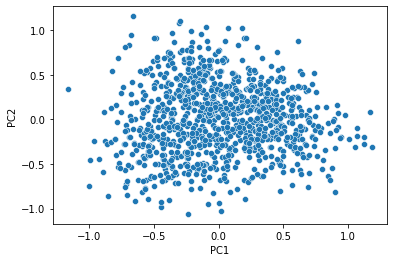

In [145]:
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data);

In [146]:
for i in [0.25, 0.5, 0.75, 1]:
    X, y = cluster_generation(a=i, k=4)
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
    n_iter_1, n_iter_2, n_iter_3 = [], [], []
    ari_1, ari_2, ari_3 = [], [], []

    for state in range(10):
        X, y = cluster_generation(a=i, random_state=state, k=4)
        pca = PCA(2) 
        pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
        p = Panom()
        centers = p.init_centroids(pca_data)
    
        model1.fit(pca_data)
        model2.fit(pca_data)
        model3.fit(pca_data);
    
        ari_1.append(adjusted_rand_score(model1.labels_,y.reshape((1000,))))
        ari_2.append(adjusted_rand_score(model2.labels_,y.reshape((1000,))))
        ari_3.append(adjusted_rand_score(model3.labels_,y.reshape((1000,))))
    
        n_iter_1.append(model1.n_iter_)
        n_iter_2.append(model2.n_iter_)
        n_iter_3.append(model3.n_iter_)
        
    print(f'ARI for k-means++ initialization: {np.mean(ari_1)}')
    print(f'ARI for panom initialization: {np.mean(ari_2)}')
    print(f'ARI for random initialization: {np.mean(ari_3)}')
    print(f'Number of iterations for k-means++ initialization: {np.mean(n_iter_1)}')
    print(f'Number of iterations for panom initialization: {np.mean(n_iter_2)}')
    print(f'Number of iterations for random initialization: {np.mean(n_iter_3)}')

ARI for k-means++ initialization: 0.21552410123477048
ARI for panom initialization: 0.21777895338140424
ARI for random initialization: 0.2138593194598004
Number of iterations for k-means++ initialization: 20.8
Number of iterations for panom initialization: 25.4
Number of iterations for random initialization: 21.9
ARI for k-means++ initialization: 0.4099011137187548
ARI for panom initialization: 0.4448687173096372
ARI for random initialization: 0.4046134530481442
Number of iterations for k-means++ initialization: 10.3
Number of iterations for panom initialization: 19.9
Number of iterations for random initialization: 15.8
ARI for k-means++ initialization: 0.46057851623521434
ARI for panom initialization: 0.5633596886782455
ARI for random initialization: 0.4586504861279844
Number of iterations for k-means++ initialization: 12.2
Number of iterations for panom initialization: 15.7
Number of iterations for random initialization: 16.3
ARI for k-means++ initialization: 0.4789212792968775
ARI f

#### Number of clusters k=11

In [147]:
for i in [0.25, 0.5, 0.75, 1]:
    X, y = cluster_generation(a=i, k=11)
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
    n_iter_1, n_iter_2, n_iter_3 = [], [], []
    ari_1, ari_2, ari_3 = [], [], []

    for state in range(10):
        X, y = cluster_generation(a=i, random_state=state, k=11)
        pca = PCA(2) 
        pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
    
        p = Panom()
        centers = p.init_centroids(pca_data)
    
        model1.fit(pca_data)
        model2.fit(pca_data)
        model3.fit(pca_data);
    
        ari_1.append(adjusted_rand_score(model1.labels_,y.reshape((1000,))))
        ari_2.append(adjusted_rand_score(model2.labels_,y.reshape((1000,))))
        ari_3.append(adjusted_rand_score(model3.labels_,y.reshape((1000,))))
    
        n_iter_1.append(model1.n_iter_)
        n_iter_2.append(model2.n_iter_)
        n_iter_3.append(model3.n_iter_)
        
    print(f'ARI for k-means++ initialization: {np.mean(ari_1)}')
    print(f'ARI for panom initialization: {np.mean(ari_2)}')
    print(f'ARI for random initialization: {np.mean(ari_3)}')
    print(f'Number of iterations for k-means++ initialization: {np.mean(n_iter_1)}')
    print(f'Number of iterations for panom initialization: {np.mean(n_iter_2)}')
    print(f'Number of iterations for random initialization: {np.mean(n_iter_3)}')

ARI for k-means++ initialization: 0.12693434275129256
ARI for panom initialization: 0.13104776445488137
ARI for random initialization: 0.12861101942035397
Number of iterations for k-means++ initialization: 17.9
Number of iterations for panom initialization: 28.5
Number of iterations for random initialization: 19.2
ARI for k-means++ initialization: 0.38828040091277566
ARI for panom initialization: 0.3701200502938492
ARI for random initialization: 0.38457855883931913
Number of iterations for k-means++ initialization: 17.5
Number of iterations for panom initialization: 31.9
Number of iterations for random initialization: 22.6
ARI for k-means++ initialization: 0.5659002187591021
ARI for panom initialization: 0.5146207660466217
ARI for random initialization: 0.566641214526748
Number of iterations for k-means++ initialization: 16.2
Number of iterations for panom initialization: 21.2
Number of iterations for random initialization: 23.4
ARI for k-means++ initialization: 0.6388958063332073
ARI 